<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

## Colab stuff

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Import Libraries

In [2]:
# import libraries

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import numpy as np
import pathlib
import PIL
import PIL.Image
import datetime

from datasets import load_dataset

In [3]:
#check gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Setup

In [4]:
#Download data
ds = load_dataset("fcakyon/pokemon-classification", name="full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/732 [00:00<?, ? examples/s]

In [7]:
# Usefull methods

#convert to tensorflow dataset for use with fit
def convert_to_tf_dataset(train_ds, val_ds, batch_size):
  train_tf_ds = train_ds.to_tf_dataset(
      columns = ['image'],
      label_cols = ['labels'],
      batch_size = batch_size,
      shuffle = True
  )

  val_tf_ds = val_ds.to_tf_dataset(
      columns = ['image'],
      label_cols = ['labels'],
      batch_size = batch_size,
      shuffle = True
  )

  return train_tf_ds, val_tf_ds

# visualize pokemons
def visualize_pokemons(data, class_names):
  plt.figure(figsize=(10, 5))
  for images, labels in data.take(1):
      for i in range(18):
          ax = plt.subplot(3, 6, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(class_names[labels[i]])
          plt.axis("off")

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


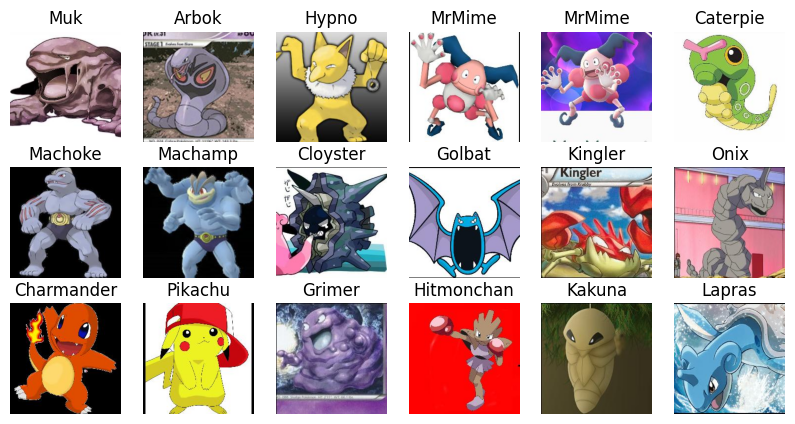

In [8]:
batch_size = 32
train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']
class_names = train_ds.features['labels'].names

train_data, val_data = convert_to_tf_dataset(train_ds=train_ds, val_ds=val_ds, batch_size=batch_size)

visualize_pokemons(data=train_data, class_names=class_names) #visualize data

## Modeling




In [17]:
# Creating the model

def create_pokedex_model(img_height, img_width, channels, num_classes):
  #input layer
  inputs = layers.Input(shape=(img_height, img_width, channels))

  #TODO:mejorar las layers
  #blocks layers
  x = layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Conv2D(64, kernel_size=5, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  #flatten layer
  x = layers.Flatten()(x)

  #Dense layer
  x = layers.Dense(num_classes, activation='relu')(x)

  #output
  outputs = layers.Dense(1, activation='softmax')(x)

  #create model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  #compile model
  #TODO: correguir loss porque no funciona
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

  return model


num_classes = len(class_names)
channels = 3
img_height = 224
img_width =224

model = create_pokedex_model(img_height, img_width, channels=3, num_classes=num_classes)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 107, 107, 64)      51264     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 179776)            0   

# Training

In [18]:
epochs = 5

# training
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


153/153 [==============================] - 33s 199ms/step - loss: 0.0000e+00 - accuracy: 0.0086 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
153/153 [==============================] - 26s 170ms/step - loss: 0.0000e+00 - accuracy: 0.0086 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


KeyboardInterrupt: 

# Evaluation

In [ ]:
# Evaluate model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
n = 475
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print("pokemon name: ", class_names[label], "label: ", label)
image

In [ ]:
#TODO: actualizar testing
img_array = tf.keras.utils.img_to_array(test_ds['image'][n])
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array) ## it is for large predict batches
predictions = model(img_array, training=False)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)